<h1>$l_{scour}$ Calculations (Monthly Only)</h1>

Dimensionless flood scour length $\frac{l_{scour}}{\overline{L_b}}$ is defined as:

\begin{equation}
\frac{l_{scour}}{\overline{L_b}} = \left [ t_{scour} \frac{\sqrt{(RgD_{50}^3)} \alpha(h_nS)^n}{h_c \overline{L_b}C_f(RD_{50})^n}) \right ]^{\frac{1}{2}}
\end{equation}


In [1]:
__author__ = "Sam Brooke"
__email__ = "sbrooke@ucsb.edu"

import math
import pandas as pd
import numpy as np
import csv
import os
import random
import pickle

os.makedirs('./scour_data_output', exist_ok=True) # Output directory for flood scour data tables


num_reps = 20000 # For Monte Carlo


# General parameters when otherwise not specified

R = 1.65 # Submerged specific gravity for quartz
g = 9.81 # gravity

# Madagascar River D50 between 60 and 90 microns
D50_microns = []
# for _ in range(num_reps): D50_microns.append(random.randrange(60, 90, 1))
D50_madagascar = np.array(D50_microns)/1000000
D50_madagascar = 90/1000000
Cf_madagascar = 0.01

# fig, axes = plt.subplots(1,1, figsize=(17,10))
# axes.hist(D50_madagascar, bins='auto', color='blue')
# axes.set_title('tscour (Madagascar average)')
# axes.set_xlabel('tscour [months]')
# plt.show() 

# Representative D50 value for Madagascar
# print(np.nanmean(D50_madagascar))


<h2>Trampush et al. 2014 - Global Slope-Depth Regression</h2>

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

font = {'family' : 'arial',
        'size'   : 14}

mpl.rc('font', **font)

# Trampush et al. 2014 Slope-Depth-Grain size coefficients
# log(S) =  alpha_0 + alpha_1 log(D50) + alpha_2 log(Hbf)
alpha_0 = -2.08
alpha_0_std = 0.036
alpha_1 = 0.254
alpha_1_std = 0.016
alpha_2 = -1.09
alpha_2_std = 0.044

# Do not vary Trampush constants
alpha_0_samples = np.full((num_reps,), alpha_0) 
alpha_1_samples = np.full((num_reps,), alpha_1)
alpha_2_samples = np.full((num_reps,), alpha_2)

scour_df_original = pd.DataFrame({'alpha_0': alpha_0_samples, 'alpha_1':alpha_1_samples, 'alpha_2':alpha_2_samples})

Hbf_trampush = lambda S, D50, alpha_0, alpha_1, alpha_2: math.exp((np.log10(S) - alpha_0 - (alpha_1 * 
                             np.log10(D50)))/alpha_2)


<h2>Dunne and Jerolmack, 2018 - Bank cohesion relation for depth</h2>

<br>
\begin{equation}
H_{bf} = \frac{1.2\tau_c}{\rho g S}
\end{equation}

In [3]:
# S = slope, tc = critical shear stress, rho = density of water, g = gravitational acceleration

Hbf_Dunne = lambda S, tc, rho, g: (1.2*tc)/(rho*g*S)


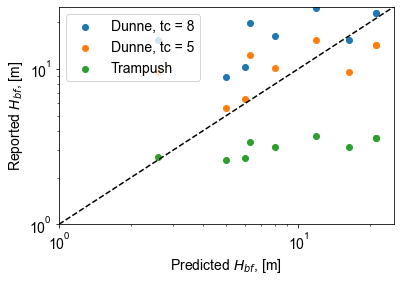

We will sample depths from both


In [4]:
# Compare Dunne and Trampush for global river compilation

avulsions_global_df = pd.read_csv('./ganti_2019_global_avulsion_table.csv') # Global compilation from Ganti et al. 2019

rivs = avulsions_global_df.River

hbf_trampush = []
hbf_dunne = []
hbf_dunne_5 = []
for index, row in avulsions_global_df.iterrows():
    hbf_dunne.append(Hbf_Dunne(row['S (x10-4)']/10000, 8, 1000, 9.81))
    hbf_dunne_5.append(Hbf_Dunne(row['S (x10-4)']/10000, 5, 1000, 9.81))
    hbf_trampush.append(Hbf_trampush(row['S (x10-4)']/10000, row['D50 [mm]']/1000, alpha_0, alpha_1, alpha_2))
                        
sc1 = plt.scatter(avulsions_global_df['Hc [m]'], hbf_dunne)
sc3 = plt.scatter(avulsions_global_df['Hc [m]'], hbf_dunne_5)
sc2 = plt.scatter(avulsions_global_df['Hc [m]'], hbf_trampush)
plt.xscale("log", nonpositive='clip')
plt.yscale("log", nonpositive='clip')
plt.ylim(bottom=1, top=25)
plt.xlim(left=1, right=25)
plt.plot([0,25], [0,25], 'k--')
plt.legend([sc1,sc3,sc2],['Dunne, tc = 8', 'Dunne, tc = 5', 'Trampush', ], loc='upper left')
plt.xlabel('Predicted $H_{bf}$, [m]')
plt.ylabel('Reported $H_{bf}$, [m]')


plt.show()

print('We will sample depths from both')

<h3>$l_{scour}$ Table Collation and Functions</h3>

In [5]:
# Get slopes for all rivers in Madagascar
slopes_df_all = pd.read_csv('./elevation_data/avulsion_slope_details.csv')

# print(slopes_df)
rivers = slopes_df_all['river']


def n_Ma(D50):
    # Ma et al. [2017] n exponent
    return (1.322 / (1 + math.exp(math.pow(10,5) * ((-1 * D50) + (1.6 * math.pow(10, -4))  )))) + 1.678
      
def a_Ma(D50):
    # Ma et al. [2017] alpha exponent
    return (0.859 / (1 + math.exp(math.pow(10,5) * (D50 - (1.6 * math.pow(10, -4))  )))) + 0.036

    
def Hbf_t(row): # Flow depth from Trampush et al., 2014
    return Hbf_trampush(row['S'], row['D50'], row['alpha_0'], 
                        row['alpha_1'], row['alpha_2'])

def Hbf_d(row): # Flow depth from Dunne and Jerolmack, 2018
    # Bank shear stress is between 6 and 10 Pa
    return Hbf_Dunne(row['S'], random.randrange(6, 11, 1), 1000, 9.78)

def Hbf_either(row): # Choose randomly whether to use flow depth from Dunne and Jerolmack, 2018 or Trampush 2014
    
    hc_dunne = Hbf_Dunne(row['S'], random.randrange(6, 11, 1), 1000, 9.78)
    hc_trampush = Hbf_trampush(row['S'], row['D50'], row['alpha_0'], 
                        row['alpha_1'], row['alpha_2'])
    
    if random.randrange(0, 2, 1): # 1 = Trampush 0 = D & J
        return hc_trampush
    else:
        return hc_dunne
    
def L_b(row): # Characteristic Backwater Length
    Hc = float(row['Hbf'])
    S = float(row['S'])
    return  Hc/S

def l_scour(row): # Calculate l_scour
    
#     print(row)
    
    Cf = float(row['Cf'])
    g = float(row['g'])
    R = float(row['R'])
    alpha_0 = float(row['alpha_0'])
    alpha_1 = float(row['alpha_1'])
    alpha_2 = float(row['alpha_2'])
    Hn = float(row['Hn'])
    Hc = float(row['Hbf'])
    S = float(row['S'])
    D50 = float(row['D50'])
    a_ma = float(a_Ma(D50))
    n_ma = float(n_Ma(D50))
    tscour = float(row['t_scour'])
    Lb = float(row['L_b'])
    
#     print('R = '+str(R))
#     print('t_scour = '+str(tscour))
#     print('g = '+str(g))
#     print('S = '+str(S))
#     print('alpha_0 = '+str(alpha_0))
#     print('alpha_1 = '+str(alpha_1))
#     print('alpha_2 = '+str(alpha_2))
#     print('D50 = '+str(D50))
#     print('n_ma = '+str(n_ma))
#     print('a_ma = '+str(a_ma))
#     print('Hbf = '+str(Hc))
#     print('Hn = '+str(Hn))
#     print('L_b = '+str(Lb))
    
    lscour_top = np.sqrt(R*g*(np.power(D50,3)))*a_ma*np.power(Hn*S, n_ma)
    lscour_bottom = Hc*Lb*Cf*np.power(R*D50,n_ma)
    lscour_Lb = np.power(tscour * (lscour_top/lscour_bottom), 0.5)
    lscour = lscour_Lb*Lb

    return lscour
        

def tau_star(row): # Ma et al., 2017

    R = float(row['R'])
    Hc = float(row['Hbf'])
    S = float(row['S'])
    D50 = float(row['D50'])
            
    return (Hc*S)/(R*D50)
    
def qs_star(row): # Dimensionless sediment discharge
    
    D50 = float(row['D50'])
    Cf = float(row['Cf'])
    a_ma = float(a_Ma(D50))
    n_ma = float(n_Ma(D50))
    tscour = float(row['t_scour'])
    Lb = float(row['L_b'])
    tau_star = float(row['tau_star'])
    
    return (a_ma*np.power(tau_star, n_ma))/Cf
    
def qs(row): # unit sediment discharge
    
    R = float(row['R'])
    g = float(row['g'])
    D50 = float(row['D50'])
    qs_star = float(row['qs_star'])
    
    return qs_star*np.sqrt(R*g*np.power(D50,3))


def Te_star(row): # Te* - dimensionless flow duration
    
    t_scour = float(row['t_scour'])
    Hc = float(row['Hbf'])
    Lb = float(row['L_b'])
    qs = float(row['qs'])
    
    return (t_scour*qs)/(Lb*Hc)


## $T_{scour}$

In [6]:
# Create discharge database from monthly data only

flood_df_monthly_global = pd.read_csv('./discharge_data/compilations/COMPILATION_flood_Qbf_Global_Monthly.csv')
flood_df_monthly_madagascar = pd.read_csv('./discharge_data/compilations/COMPILATION_flood_Qbf_Madagascar.csv')

flood_df = flood_df_monthly_global.append(flood_df_monthly_madagascar).reset_index(drop=True)


## Slope

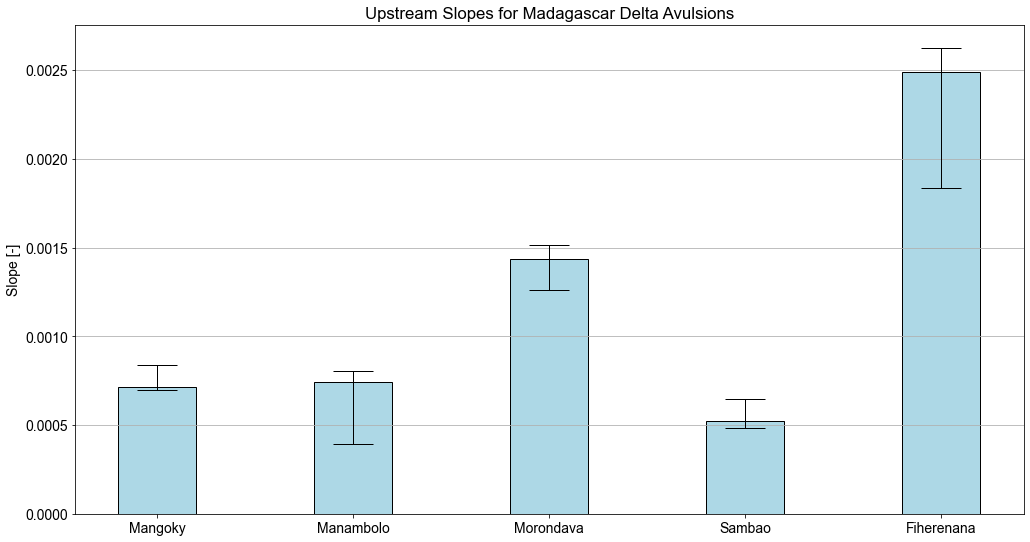

In [7]:
# Madagascar river slope check

def cap(x):
    return x.capitalize()

fig, ax = plt.subplots(figsize=(17, 9))

bar_width = 0.4

slopes_delta = slopes_df_all.loc[slopes_df_all.type == 'delta']
xticks = np.array(range(0, len(slopes_delta.upstream_slope)))
b1 = ax.bar(xticks, slopes_delta.upstream_slope, width=bar_width, 
            color='lightblue', linewidth=1, edgecolor='k', 
            error_kw=dict(lw=1, capsize=20, capthick=1), 
            yerr =[slopes_delta.upstream_slope-slopes_delta.upstream_25, 
                   slopes_delta.upstream_75-slopes_delta.upstream_slope])

# ax.set_xlabel('River')
ax.set_ylabel('Slope [-]')
ax.set_xticks(xticks)
ax.set_title('Upstream Slopes for Madagascar Delta Avulsions')
ax.set_xticklabels(slopes_delta.river.apply(cap))
ax.yaxis.grid() # horizontal lines
fig.savefig('./figures/delta_avulsion_channel_slopes.pdf')
        

<h2>Calculate $L_{scour}$</h2>

<h3>Global Avulsions Data (Ganti et al., 2019)</h3>

In [8]:
# Target columns for table
delta_rivers = []
river_classification = [] # This study or global dataset [study|global]
La_list = [] # Observed avulsion lengths [km]
La_error = []
Lscour_list = [] # Flood scour lengths [km]
Lscour_error = []
Lb_list = [] # Characteristic backwater lengths [km]
Lb_error = []
Tscour_list = [] # Flood scour duration (T_scour) lists [km]
Tscour_std = []
Tscour_std_error = []
Tscour_source = [] # RivDis, GRDC etc.
S_list = [] # Slope lists
S_error = []
Hbf_list = [] # Characteristic flow depth [m]
Hbf_error = []
D50_list = [] # Median grain size [m]
Cf_list = [] # Coefficient of friction

Lb_std_error = [] # Lb standard error
Lscour_std_error = [] # Lscour standard error

qs_list = []
qs_std_list = []
qs_std_err_list = []

qs_star_list = []
qs_star_std_list = []
qs_star_std_err_list = []

tau_star_list = []
tau_star_std_list = []
tau_star_std_err_list = []

Te_star_list = []
Te_star_std_list = []
Te_star_std_err_list = []


# Hn - uniform distribution from flood multiples (Hn = Hc*flood_multiple)
flood_multiple = []
for _ in range(num_reps): flood_multiple.append(random.randrange(2, 5, 1)) # Floods are between 2 and 4 time bankfull
# e.g. (Gibling 2006; Ganti et al. 2014a; Trower et al. 2018; Ganti et al., 2019)

avulsions_global_df = pd.read_csv('./ganti_2019_global_avulsion_table.csv') # Global compilation from Ganti et al. 2019

river_ids = avulsions_global_df['River']

for r in river_ids:
    print(r)
    
    river_classification.append('global')
    
    av_df = avulsions_global_df.loc[avulsions_global_df['River'] == r]
    
    delta_rivers.append(av_df['river_name'].iloc[0].lower())
    
    # Flood duration and recurrence interval
    if (r == 'MISSISSIPPI_RIVER_1') or (r == 'MISSISSIPPI_RIVER_2'):
        fl_df = flood_df.loc[flood_df['River'] == 'MISSISSIPPI_RIVER']
    else:
        fl_df = flood_df.loc[flood_df['River'] == r]
    
    t_scour_mean = fl_df['Tscour (months)'].iloc[0]
    t_scour_err = fl_df['Tscour std. err.'].iloc[0]
    t_scour_source = fl_df['Source'].iloc[0]
    
    # Monte Carlo for T_scour
    seconds_in_month = 2.628e+6
    tscour_riv = np.random.normal(loc=t_scour_mean, scale=t_scour_err, size=(num_reps,))*seconds_in_month
    tscour_riv[tscour_riv<0] = np.nan
    
    S = av_df['S (x10-4)'].iloc[0]*0.0001
    D50 = av_df['D50 [mm]'].iloc[0]/1000
    Cf = av_df['Cf'].iloc[0]
    Hbf = av_df['Hc [m]'].iloc[0]
    scour_df = scour_df_original.copy()
    scour_df['River'] = av_df['river_name'].iloc[0].lower().capitalize()
    scour_df['S'] = S
    scour_df['D50'] = D50
    scour_df['Cf'] = Cf
    scour_df['g'] = g
    scour_df['R'] = R
    scour_df['Hbf'] = av_df['Hc [m]'].iloc[0]
    scour_df['Flood_multiple'] = flood_multiple # What multiple of Hbf are we using (2-4x)
    scour_df['Hn'] = scour_df['Hbf']*scour_df['Flood_multiple']
    scour_df['t_scour'] = tscour_riv
    scour_df['L_b'] = av_df['Lb [km]'].iloc[0]*1000
    scour_df['l_scour'] = scour_df.apply(l_scour, axis=1)
    scour_df['L_A'] = av_df['LA [km]'].iloc[0]*1000
    
    scour_df['tau_star'] = scour_df.apply(tau_star, axis=1)
    scour_df['qs_star'] = scour_df.apply(qs_star, axis=1)
    scour_df['qs'] = scour_df.apply(qs, axis=1)
    scour_df['Te_star'] = scour_df.apply(Te_star, axis=1)
    
    
    lscour_mean = scour_df['l_scour'].mean()
    lscour_std = scour_df['l_scour'].std()
    lb_mean = scour_df['L_b'].mean()
    lb_std = scour_df['L_b'].std()
    La_list.append(av_df['LA [km]'].iloc[0])
    La_error.append(av_df['LA error [km]'].iloc[0])
    
    # Representative L_scour values (using just the mean values)
    D50_rep = D50
    S_rep = S
    Hbf_rep = Hbf
    n_ma_rep = n_Ma(D50_rep)
    a_ma_rep = a_Ma(D50_rep)
    Lb_rep = Hbf_rep/S_rep
    
    tau_star_rep = (Hbf_rep*S_rep)/(R*D50_rep)
    qs_star_rep = (a_ma_rep*np.power(tau_star_rep, n_ma_rep))/Cf
    qs_rep = qs_star_rep*np.sqrt(R*g*np.power(D50_rep,3)) # Unit sediment discharge
    
    Te_star_rep = round((scour_df['t_scour'].mean()*qs_rep)/(Lb_rep*Hbf_rep), 5)
    
    tau_star_std = round(scour_df['tau_star'].std(), 5)
    tau_star_std_err = round((scour_df['tau_star'].std()/np.sqrt(len(scour_df['tau_star']))),5)

    qs_star_std = round(scour_df['qs_star'].std(), 5)
    qs_star_std_err = round((scour_df['qs_star'].std()/np.sqrt(len(scour_df['qs_star']))),5)

    qs_std = round(scour_df['qs'].std(), 5)
    qs_std_err = round((scour_df['qs'].std()/np.sqrt(len(scour_df['qs']))),5)  

    Te_star_std = round(scour_df['Te_star'].std(), 5)
    Te_star_std_err = round((scour_df['Te_star'].std()/np.sqrt(len(scour_df['Te_star']))),5)

    
    lscour_top = np.sqrt(R*g*(np.power(D50_rep,3)))*a_ma_rep*np.power((Hbf_rep*3)*S_rep, n_ma_rep)
    lscour_bottom = Hbf_rep*Lb_rep*Cf*np.power(R*D50_rep,n_ma_rep)
    lscour_Lb = np.power(np.nanmean(tscour_riv) * (lscour_top/lscour_bottom), 0.5)
    lscour_rep = lscour_Lb*Lb_rep

    Lscour_list.append(round(lscour_rep/1000,2))
    Lscour_error.append(round(lscour_std/1000,2))
    Lb_list.append(round(Lb_rep/1000, 3))
    Lb_error.append(round(lb_std/1000, 3))
    Tscour_list.append(round(scour_df['t_scour'].mean()/seconds_in_month,2))
    Tscour_std.append(round(scour_df['t_scour'].std()/seconds_in_month,2))
    Tscour_std_error.append(round((scour_df['t_scour'].std()/seconds_in_month)/np.sqrt(len(scour_df['t_scour'])),5))
    S_list.append(round(S_rep,6))
    S_error.append((np.max(scour_df['S'])-np.min(scour_df['S']))/2)
    Hbf_list.append(round(Hbf_rep,2))
    Hbf_error.append(round(scour_df['Hbf'].std(),2))
    D50_list.append(round(D50_rep,8))
    Cf_list.append(Cf)
    Tscour_source.append(t_scour_source)
    
    tau_star_list.append(tau_star_rep)
    tau_star_std_list.append(tau_star_std)
    tau_star_std_err_list.append(tau_star_std_err)

    qs_star_list.append(qs_star_rep)
    qs_star_std_list.append(qs_star_std)
    qs_star_std_err_list.append(qs_star_std_err)
    
    qs_list.append(qs_rep)
    qs_std_list.append(qs_star_std)
    qs_std_err_list.append(qs_star_std_err)

    Te_star_list.append(Te_star_rep)
    Te_star_std_list.append(Te_star_std)
    Te_star_std_err_list.append(Te_star_std_err)
    
    Lb_std_error.append(round((lb_std/1000)/np.sqrt(len(scour_df['L_b'])),2))
    Lscour_std_error.append(round((lscour_std/1000)/np.sqrt(len(scour_df['l_scour'])),2))
    
    # Save to disk
    scour_df.to_csv(os.path.join('./scour_data_output', av_df['river_name'].iloc[0].lower().capitalize()+'.csv')) 

print('---')    
print('COMPLETE')

NILE_RIVER
MAGDALENA,_RIO
ORINOCO,_RIO
RHINE_RIVER
DANUBE_RIVER
PARANA,_RIO
MISSISSIPPI_RIVER_1
MISSISSIPPI_RIVER_2
YELLOW_RIVER
---
COMPLETE


<h3>Madagascar Rivers</h3>

In [9]:
slopes_delta = slopes_df_all.loc[slopes_df_all.type == 'delta'] # Only choose rivers designated as deltas

for r in rivers:
    
    print(r)
    scour_df = scour_df_original.copy()
    slopes_df = slopes_df_all.loc[slopes_df_all['river'] == r]
    
    if slopes_df.type.iloc[0] == 'delta': 
        
        river_classification.append('study')
        
        avulsion_distance = slopes_df.distance.iloc[0]
        
        delta_rivers.append(r)
        
        # Uniform slope within IQR
        S = []
        for _ in range(num_reps): S.append(random.uniform(slopes_df['upstream_25'].iloc[0], slopes_df['upstream_75'].iloc[0])) 
        
        # We don't have discharge data for FIHERENANA or SAMBAO, pick closest river stations
        if r.upper() == 'FIHERENANA':
             fl_df = flood_df.loc[flood_df['River'] == 'MANGOKY']

        elif r.upper() == 'SAMBAO':
             fl_df = flood_df.loc[flood_df['River'] == 'BETSIBOKA']
        
        else:
            fl_df = flood_df.loc[flood_df['River'] == r.upper()]
        
        
        if fl_df.size: # Rivers are listed in flood discharge database
            t_scour_mean = fl_df['Tscour (months)'].iloc[0]
            t_scour_err = fl_df['Tscour std. err.'].iloc[0]
            t_scour_source = fl_df['Source'].iloc[0]
            seconds_in_month = 2.628e+6
            
            # Monte Carlo for T_scour
            tscour_riv = np.random.normal(loc=t_scour_mean, scale=t_scour_err, size=(num_reps,))*seconds_in_month
            tscour_riv[tscour_riv<0] = np.nan # Remove any negative times
        else:
            print('Cannot find Tscour value for '+r.capitalize())
          
        scour_df['River'] = r.capitalize()
        scour_df['S'] = S
        scour_df['D50'] = D50_madagascar
        scour_df['Cf'] = Cf_madagascar
        scour_df['g'] = g
        scour_df['R'] = R
        scour_df['Hbf'] = scour_df.apply(Hbf_either, axis=1)
        scour_df['Flood_multiple'] = flood_multiple
        scour_df['Hn'] = scour_df['Hbf']*scour_df['Flood_multiple']
        scour_df['t_scour'] = tscour_riv
        scour_df['L_b'] = scour_df.apply(L_b, axis=1)
        scour_df['l_scour'] = scour_df.apply(l_scour, axis=1)
        scour_df['L_A'] = avulsion_distance
        
        scour_df['tau_star'] = scour_df.apply(tau_star, axis=1)
        scour_df['qs_star'] = scour_df.apply(qs_star, axis=1)
        scour_df['qs'] = scour_df.apply(qs, axis=1)
        scour_df['Te_star'] = scour_df.apply(Te_star, axis=1)
    
        lscour_mean = scour_df['l_scour'].mean()
        lscour_std = scour_df['l_scour'].std()
        lb_mean = scour_df['L_b'].mean()
        lb_std = scour_df['L_b'].std()
        
        # Representative L_scour values (using just the mean values)
        D50_rep = np.nanmean(D50_madagascar)
        S_rep = np.nanmedian(S)
        Hbf_rep = Hbf_Dunne(S_rep, 8, 1000, 9.81) # Use DJ depth as representative
        n_ma_rep = n_Ma(D50_rep)
        a_ma_rep = a_Ma(D50_rep)
        Lb_rep = Hbf_rep/S_rep
        lscour_top = np.sqrt(R*g*(np.power(D50_rep,3)))*a_ma_rep*np.power((Hbf_rep*3)*S_rep, n_ma_rep)
        lscour_bottom = Hbf_rep*Lb_rep*Cf_madagascar*np.power(R*D50_rep,n_ma_rep)
        lscour_Lb = np.power(np.nanmean(tscour_riv) * (lscour_top/lscour_bottom), 0.5)
        lscour_rep = lscour_Lb*Lb_rep
        
        tau_star_rep = (Hbf_rep*S_rep)/(R*D50_rep)
        qs_star_rep = (a_ma_rep*np.power(tau_star_rep, n_ma_rep))/Cf_madagascar
        qs_rep = qs_star_rep*np.sqrt(R*g*np.power(D50_rep,3)) # Unit sediment discharge
        Te_star_rep = round((scour_df['t_scour'].mean()*qs_rep)/(Lb_rep*Hbf_rep), 5)
        
        tau_star_std = round(scour_df['tau_star'].std(), 5)
        tau_star_std_err = round((scour_df['tau_star'].std()/np.sqrt(len(scour_df['tau_star']))),5)

        qs_star_std = round(scour_df['qs_star'].std(), 5)
        qs_star_std_err = round((scour_df['qs_star'].std()/np.sqrt(len(scour_df['qs_star']))),5)

        qs_std = round(scour_df['qs'].std(), 5)
        qs_std_err = round((scour_df['qs'].std()/np.sqrt(len(scour_df['qs']))),5)  

        Te_star_std = round(scour_df['Te_star'].std(), 5)
        Te_star_std_err = round((scour_df['Te_star'].std()/np.sqrt(len(scour_df['Te_star']))),8)

        La_list.append(round(avulsion_distance/1000,2))
        La_error.append(0)
        Lscour_list.append(round(lscour_rep/1000,2))
        Lscour_error.append(round(lscour_std/1000,2))
        Lb_list.append(round(Lb_rep/1000, 3))
        Lb_error.append(round(lb_std/1000, 3))
        Tscour_list.append(round(scour_df['t_scour'].mean()/seconds_in_month,2))
        Tscour_std.append(round(scour_df['t_scour'].std()/seconds_in_month,2))
        Tscour_std_error.append(round((scour_df['t_scour'].std()/seconds_in_month)/np.sqrt(len(scour_df['t_scour'])),5))
        S_list.append(round(S_rep,6))
        S_error.append((np.max(scour_df['S'])-np.min(scour_df['S']))/2)
        Hbf_list.append(round(Hbf_rep,2))
        Hbf_error.append(round(scour_df['Hbf'].std(),2))
        D50_list.append(round(D50_rep,8))
        Cf_list.append(Cf_madagascar)
        Tscour_source.append(t_scour_source)
        
        Lb_SE = round(((lb_std/1000)/np.sqrt(len(scour_df['L_b']))),5)
        Lb_std_error.append(Lb_SE)
        
        Lscour_SE = round(((lscour_std/1000)/np.sqrt(len(scour_df['l_scour']))),5)
        Lscour_std_error.append(Lscour_SE)
        
        tau_star_list.append(tau_star_rep)
        tau_star_std_list.append(tau_star_std)
        tau_star_std_err_list.append(tau_star_std_err)

        qs_star_list.append(qs_star_rep)
        qs_star_std_list.append(qs_star_std)
        qs_star_std_err_list.append(qs_star_std_err)

        qs_list.append(qs_rep)
        qs_std_list.append(qs_star_std)
        qs_std_err_list.append(qs_star_std_err)

        Te_star_list.append(Te_star_rep)
        Te_star_std_list.append(Te_star_std)
        Te_star_std_err_list.append(Te_star_std_err)
    
        # Dimensionless flow duration
                        
        scour_df.to_csv(os.path.join('./scour_data_output',r.capitalize()+'.csv')) # Save to disk

# delta_location_df = pd.DataFrame({'River':delta_rivers, 'From':river_classification, 
#                                   'S [-]':S_list, 'S_std_dev [-]':S_error, 'D50 [m]':D50_list, 
#                                   'Hbf [m]':Hbf_list, 'Hbf_std_dev [m]':Hbf_error, 
#                                  'T*':tau_star_list, 'T*_std_dev':tau_star_std_list, 'T*_std_err':tau_star_std_err_list,
#                                   'Cf':Cf_list,
#                                   't_scour [months]':Tscour_list, 't_scour_std_dev [months]':Tscour_std, 't_scour_std_err [months]':Tscour_std_error, 
#                                   'L_A [km]':La_list,
#                                   'L_b [km]':Lb_list, 'L_b_std_dev [km]':Lb_error,'L_b_std_err [km]':Lb_std_error,
#                                   'L_scour [km]':Lscour_list,'L_scour_std_dev [km]':Lscour_error, 'L_scour_std_err [km]':Lscour_std_error, 
#                                   'qs*': qs_star_list, 'qs* std_dev': qs_star_std_list, 'qs* std_err': qs_star_std_err_list, 
#                                   'qs [ms^2/s]': qs_list, 'qs_std_dev [ms^2/s]': qs_std_list, 'qs_std_err [ms^2/s]': qs_std_err_list,
#                                   'Te*': Te_star_list, 'Te* std_dev': Te_star_std_list, 'Te* std_err': Te_star_std_err_list})

delta_location_df = pd.DataFrame({'River':delta_rivers, 'From':river_classification, 
                                  'S [-]':S_list, 'S_error [-]':S_error, 'D50 [m]':D50_list, 
                                  'Hc [m]':Hbf_list, 'Hc_std_dev [m]':Hbf_error, 
                                  'Cf':Cf_list,
                                  't_scour [months]':Tscour_list, 't_scour_std_dev [months]':Tscour_std, 't_scour_std_err [months]':Tscour_std_error, 
                                  't_scour source': Tscour_source, 'L_A [km]':La_list,'L_A_error [km]':La_error,
                                  'L_b [km]':Lb_list, 'L_b_std_dev [km]':Lb_error,'L_b_std_err [km]':Lb_std_error,
                                  'L_scour [km]':Lscour_list,'L_scour_std_dev [km]':Lscour_error, 'L_scour_std_err [km]':Lscour_std_error, 
                                  'qs*': qs_star_list,
                                  'qs [ms^2/s]': qs_list,
                                  'T_e*': Te_star_list, 'T_e* std_dev': Te_star_std_list, 'T_e* std_err': Te_star_std_err_list})


delta_location_df.to_csv(os.path.join('./scour_data_output', 'l_scour_table_monthly_only.csv')) # Save to disk

print('---')  
print('COMPLETE')

delta_data_hash = {
    'delta_dataframe': delta_location_df,
    'delta_rivers': delta_rivers,
    'river_classification': river_classification,
    'La_error': La_error
}
    
with open('delta_data.pickle', 'wb') as handle:
    pickle.dump(delta_data_hash, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

mangoky
betsiboka
mahajamba
manambolo
morondava
sambao
fiherenana
---
COMPLETE


<h3>Plot $L_b$-$L_A$ versus $l_{scour}$-$L_A$<h3>

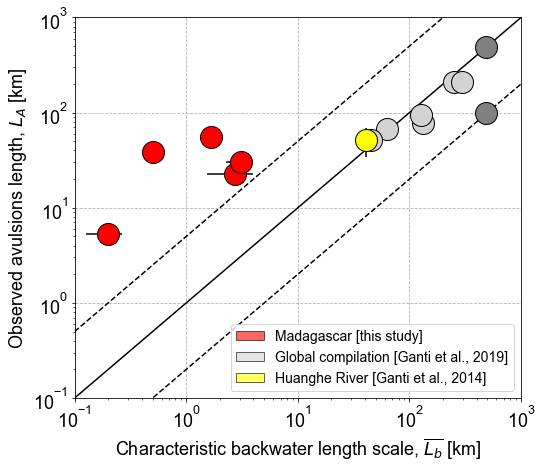

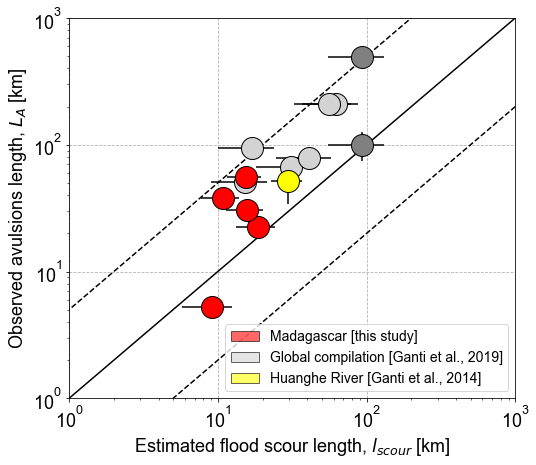

In [10]:
# CREATE FIGURE 3 IN MANUSCRIPT

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log", nonpositive='clip')
ax.set_yscale("log", nonpositive='clip')

refplot = np.linspace(.1,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5

ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed') 

annotate_text = []

os.makedirs('./figures', exist_ok=True)

for k, r in enumerate(delta_rivers):
    
    if river_classification[k] == 'study':
        col = 'red'
    else:
        if r == 'huanghe':
            col ='yellow'
        else:
            if (r == 'mississippi_1'):
                col = 'gray'
            elif (r == 'mississippi_2'):
                col = 'gray'
            else:
                col = 'lightgray'

    ax.errorbar(Lb_list[k], La_list[k], yerr=La_error[k], xerr=Lb_error[k], 
                fmt='o', ms=22, markerfacecolor=col, ecolor='black', markeredgecolor='black')
    # ***UNCOMMENT BELOW FOR ANNOTATING POINTS WITH RIVERS**
#     ax.annotate(r.capitalize(), xy=(Lb_list[k], La_list[k]), xytext=(5, -5), xycoords='data', 
#                 textcoords='offset points', fontsize=12)

# ylim must be set after errorbar to allow errorbar to autoscale limits
ax.set_ylim(bottom=.1, top=1000)
ax.set_xlim(left=.1, right=1000)
ax.set_ylabel('Observed avulsions length, $L_A$ [km]')
ax.set_xlabel('Characteristic backwater length scale, $\overline{L_b}$ [km]')

legend_elements = [Patch(facecolor='red', edgecolor='black', alpha=0.6, label='Madagascar [this study]'),
                  Patch(facecolor='lightgray', edgecolor='black', alpha=0.6, label='Global compilation [Ganti et al., 2019]'),
                  Patch(facecolor='yellow', edgecolor='black', alpha=0.6, label='Huanghe River [Ganti et al., 2014]')]

ax.legend(handles=legend_elements, loc='lower right', fontsize=14)

plt.grid(True,which="major", linestyle='--')
plt.show()
fig.savefig('figures/LA_Lb_monthly_only.pdf', transparent=True)


fig, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log", nonpositive='clip')
ax.set_yscale("log", nonpositive='clip')

refplot = np.linspace(.1,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5

ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed') 

annotate_text = []

for k, r in enumerate(delta_rivers):
    
    if river_classification[k] == 'study':
        col = 'red'        
    else:
        if r == 'huanghe':
            col ='yellow'
        else:
            if (r == 'mississippi_1'):
                col = 'gray'
            elif (r == 'mississippi_2'):
                col = 'gray'
            else:
                col = 'lightgray'
            
    ax.errorbar(Lscour_list[k], La_list[k], yerr=La_error[k], xerr=Lscour_error[k], fmt='o', ms=22, markerfacecolor=col, ecolor='black',  markeredgecolor='black')
    # ***UNCOMMENT BELOW FOR ANNOTATING POINTS WITH RIVERS**
#     ax.annotate(r.capitalize(), xy=(Lscour_list[k], La_list[k]), xytext=(5, -5), xycoords='data', 
#                 textcoords='offset points', fontsize=12)

                                                                
# ylim must be set after errorbar to allow errorbar to autoscale limits
ax.set_ylim(bottom=1, top=1000)
ax.set_xlim(left=1, right=1000)
ax.set_ylabel('Observed avulsions length, $L_A$ [km]')
ax.set_xlabel('Estimated flood scour length, $l_{scour}$ [km]')

legend_elements = [Patch(facecolor='red', edgecolor='black', alpha=0.6, label='Madagascar [this study]'),
                  Patch(facecolor='lightgray', edgecolor='black', alpha=0.6, label='Global compilation [Ganti et al., 2019]'),
                  Patch(facecolor='yellow', edgecolor='black', alpha=0.6, label='Huanghe River [Ganti et al., 2014]')]

ax.legend(handles=legend_elements, loc='lower right', fontsize=14)
plt.grid(True,which="major", linestyle='--')
plt.show()
fig.savefig('figures/LA_Lscour_monthly_only.pdf', transparent=True)

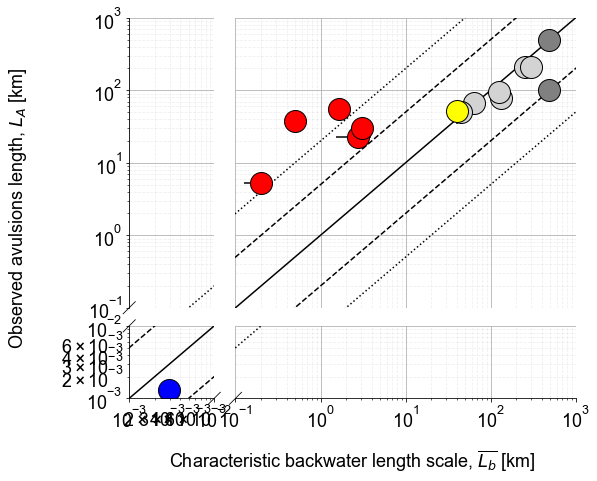

/usr/local/lib/python3.8/site-packages/brokenaxes.py:313: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  return self.big_ax.legend(h, l, *args, **kwargs)


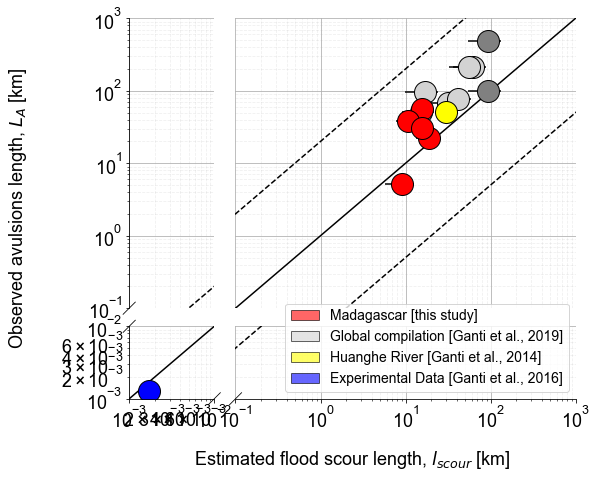

In [11]:
# ALTERNATE VERSION WITH BROKEN AXES FOR EXPERIMENTAL DATA
from brokenaxes import brokenaxes

# Ganti et al., 2016 experiment data
xp = {
    'S': 0.0033,
    'Hc': 0.0095,
    'Lb': 0.0029,
    'Lb_err': 0,
    'LA': 0.0013,
    'LA_err': 0.0003,
    'Lscour': 0.00173,
    'Lscour_err': 0
}

# Read data we saved above
with open('delta_data.pickle', 'rb') as handle:
    delta_data_hash = pickle.load(handle)

delta_location_df = delta_data_hash['delta_dataframe']
delta_rivers = delta_data_hash['delta_rivers']
La_error = delta_data_hash['La_error']
La_list = delta_location_df['L_A [km]']
Lb_list = delta_location_df['L_b [km]']
Lb_error = delta_location_df['L_b_std_dev [km]']
Lscour_list = delta_location_df['L_scour [km]']
Lscour_error = delta_location_df['L_scour_std_dev [km]']
river_classification = delta_location_df['From']

fig = plt.figure(figsize=(8, 7))

ax = brokenaxes(xlims=((0.001, 0.01), (0.1, 1000)), ylims=((0.001, 0.01), (0.1, 1000)), hspace=0.1, wspace=0.1, xscale='log', yscale='log')
# ax.set_ylim(bottom=0.0001, top=1000)
# ax.set_xlim(left=0.0001, right=1000)

refplot = np.logspace(-4, 4, 100000)
refplot_upper = refplot*5
refplot_lower = refplot/5

refplot_upper2 = refplot*20
refplot_lower2 = refplot/20

ax.loglog(refplot,refplot, color='k')
ax.loglog(refplot,refplot_upper, color='k', linestyle='dashed')
ax.loglog(refplot, refplot_lower, color='k', linestyle='dashed') 

ax.loglog(refplot, refplot_upper2, color='k', linestyle='dotted')
ax.loglog(refplot, refplot_lower2, color='k', linestyle='dotted') 

annotate_text = []

os.makedirs('./figures', exist_ok=True)

for k, r in enumerate(delta_rivers):
    
    if river_classification[k] == 'study':
        col = 'red'
    else:
        if r == 'huanghe':
            col ='yellow'
        else:
            if (r == 'mississippi_1'):
                col = 'gray'
            elif (r == 'mississippi_2'):
                col = 'gray'
            else:
                col = 'lightgray'
                        
    ax.errorbar(Lb_list[k], La_list[k], yerr=La_error[k], xerr=Lb_error[k], 
                fmt='o', ms=22, markerfacecolor=col, ecolor='black', markeredgecolor='black')

    # ***UNCOMMENT BELOW FOR ANNOTATING POINTS WITH RIVERS**
#     ax.annotate(r.capitalize(), xy=(Lb_list[k], La_list[k]), xytext=(5, -5), xycoords='data', 
#                 textcoords='offset points', fontsize=12)
    
ax.errorbar([xp['Lb']], [xp['LA']], yerr=[xp['LA_err']], xerr=[xp['Lb_err']], 
            fmt='o', ms=22, markerfacecolor='blue', ecolor='black', markeredgecolor='black')


# ylim must be set after errorbar to allow errorbar to autoscale limits

ax.set_ylabel('Observed avulsions length, $L_A$ [km]', labelpad=100)
ax.set_xlabel('Characteristic backwater length scale, $\overline{L_b}$ [km]', labelpad=50)

legend_elements = [Patch(facecolor='red', edgecolor='black', alpha=0.6, label='Madagascar [this study]'),
                  Patch(facecolor='lightgray', edgecolor='black', alpha=0.6, label='Global compilation [Ganti et al., 2019]'),
                  Patch(facecolor='yellow', edgecolor='black', alpha=0.6, label='Huanghe River [Ganti et al., 2014]'),
                  Patch(facecolor='blue', edgecolor='black', alpha=0.6, label='Experimental Data [Ganti et al., 2016]')]

# ax.legend(handles=legend_elements, loc='lower right', fontsize=14)
ax.grid(axis='both', which='major', ls='-')
ax.grid(axis='both', which='minor', ls='--', alpha=0.2)

plt.show()
fig.savefig('figures/LA_Lb_monthly_only_alternate.pdf', transparent=True)


fig = plt.figure(figsize=(8, 7))
ax = brokenaxes(xlims=((0.001, 0.01), (3, 1000)), ylims=((0.001, 0.01), (3, 1000)), hspace=0.1, wspace=0.1, xscale='log', yscale='log')

# refplot = np.logspace(-4, 4, 100000)
# refplot_upper = refplot*5
# refplot_lower = refplot/5

refplot = np.logspace(-4, 4, 100000)
refplot_upper = refplot*20
refplot_lower = refplot/20


ax.loglog(refplot, refplot, color='k')
ax.loglog(refplot, refplot_upper, color='k', linestyle='dashed')
ax.loglog(refplot, refplot_lower, color='k', linestyle='dashed') 

annotate_text = []

for k, r in enumerate(delta_rivers):
    
    if river_classification[k] == 'study':
        col = 'red'        
    else:
        if r == 'huanghe':
            col ='yellow'
        else:
            if (r == 'mississippi_1'):
                col = 'gray'
            elif (r == 'mississippi_2'):
                col = 'gray'
            else:
                col = 'lightgray'
            
    ax.errorbar(Lscour_list[k], La_list[k], yerr=La_error[k], xerr=Lscour_error[k], fmt='o', ms=22, markerfacecolor=col, ecolor='black',  markeredgecolor='black')
    # ***UNCOMMENT BELOW FOR ANNOTATING POINTS WITH RIVERS**
#     ax.annotate(r.capitalize(), xy=(Lscour_list[k], La_list[k]), xytext=(5, -5), xycoords='data', 
#                 textcoords='offset points', fontsize=12)

ax.errorbar([xp['Lscour']], [xp['LA']], yerr=[xp['LA_err']], xerr=[xp['Lscour_err']], 
        fmt='o', ms=22, markerfacecolor='blue', ecolor='black', markeredgecolor='black')
    
                                                                
# ylim must be set after errorbar to allow errorbar to autoscale limits
ax.set_ylabel('Observed avulsions length, $L_A$ [km]', labelpad=100)
ax.set_xlabel('Estimated flood scour length, $l_{scour}$ [km]', labelpad=50)
ax.grid(axis='both', which='major', ls='-')
ax.grid(axis='both', which='minor', ls='--', alpha=0.2)

legend_elements = [Patch(facecolor='red', edgecolor='black', alpha=0.6, label='Madagascar [this study]'),
                  Patch(facecolor='lightgray', edgecolor='black', alpha=0.6, label='Global compilation [Ganti et al., 2019]'),
                  Patch(facecolor='yellow', edgecolor='black', alpha=0.6, label='Huanghe River [Ganti et al., 2014]'),
                  Patch(facecolor='blue', edgecolor='black', alpha=0.6, label='Experimental Data [Ganti et al., 2016]')]

ax.legend(handles=legend_elements, loc='lower right', fontsize=14)
plt.grid(True,which="major", linestyle='--')
plt.show()
fig.savefig('figures/LA_Lscour_monthly_only_alternate.pdf', transparent=True)

/usr/local/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


3.101704645380853


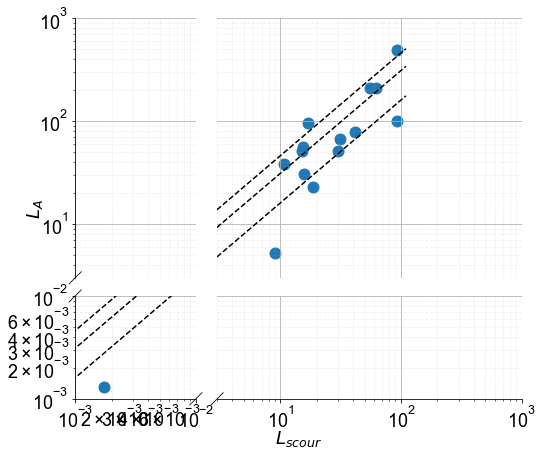

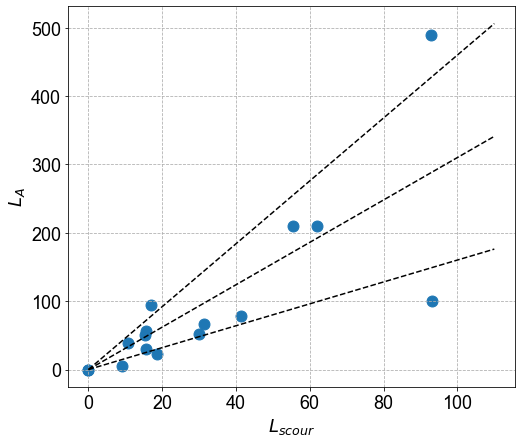

In [12]:
# Linear Regression

from scipy.optimize import curve_fit
import statsmodels.api as sm

lscour_list_lin_reg = list(Lscour_list)
LA_list_in_reg = list(La_list)
LA_list_in_reg.insert(0, xp['LA'])
lscour_list_lin_reg.insert(0, xp['Lscour'])
LA_list_in_reg.insert(0, 0)
lscour_list_lin_reg.insert(0, 0)

sm.add_constant(np.zeros((1,len(LA_list_in_reg))))
model = sm.OLS(LA_list_in_reg, lscour_list_lin_reg)
result = model.fit()
result.summary()

m = result.params[0]
print(m)
std_error = 1.5 # What covers most values?

fig = plt.figure(figsize=(8, 7))
ax = brokenaxes(xlims=((0.001, 0.01), (3, 1000)), ylims=((0.001, 0.01), (3, 1000)), hspace=0.1, wspace=0.1, xscale='log', yscale='log')

x_fit = np.linspace(0.0001, 110, 100)
y_fit_1 = x_fit*(m-std_error)
y_fit_2 = x_fit*m
y_fit_3 = x_fit*(m+std_error)
ax.scatter(lscour_list_lin_reg, LA_list_in_reg, s=120)

ax.loglog(x_fit, y_fit_1, color='k', linestyle='dashed')
ax.loglog(x_fit, y_fit_2, color='k', linestyle='dashed') 
ax.loglog(x_fit, y_fit_3, color='k', linestyle='dashed') 
ax.grid(axis='both', which='major', ls='-')
ax.grid(axis='both', which='minor', ls='--', alpha=0.2)
ax.set_xlabel('$L_{scour}$')
ax.set_ylabel('$L_{A}$')
plt.grid(True,which="major", linestyle='--')

    
# Non-log plot

fig, ax = plt.subplots(figsize=(8, 7))

x_fit = np.linspace(0.0001, 110, 100)
y_fit_1 = x_fit*(m-std_error)
y_fit_2 = x_fit*m
y_fit_3 = x_fit*(m+std_error)
ax.scatter(lscour_list_lin_reg, LA_list_in_reg, s=120)

ax.plot(x_fit, y_fit_1, color='k', linestyle='dashed')
ax.plot(x_fit, y_fit_2, color='k', linestyle='dashed') 
ax.plot(x_fit, y_fit_3, color='k', linestyle='dashed') 
ax.grid(axis='both', which='major', ls='-')
ax.grid(axis='both', which='minor', ls='--', alpha=0.2)
# plt.plot(x_fit, y_fit_1)
# plt.plot(x_fit, y_fit_2)
# plt.plot(x_fit, y_fit_3)
ax.set_xlabel('$L_{scour}$')
ax.set_ylabel('$L_{A}$')
plt.grid(True,which="major", linestyle='--')